In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [40]:
interim_dir = "../../data/interim"
processed_dir = "../../data/processed"

outliers_output_file_path = f'{processed_dir}/access_mode_walk_distance_outliers.csv'

data_model_file = os.path.join(processed_dir, "data_model_output.csv")

In [41]:
data_model_df = pd.read_csv(data_model_file)
data_model_df.head()
data_model_df = data_model_df[
    (data_model_df['is_completed'] == 1) &
    (data_model_df['record_type_synthetic'] == 0) #&
    # (data_model_df['submit']==True)
    ]

C:\Users\mwe\AppData\Local\Temp\ipykernel_8416\3316024677.py:1: DtypeWarning: Columns (1,13,14,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,54,55,59,65,69,74,77,78,80,82,83,86,93,95,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,132,142,147,150,151,152,155,156,157,167,169,177,179,196,197,198,201,210,211,216,223,237,239,240,241,242,243,244,246,248,249,273,283,284,285,288,291,295,296,297,299,300,335,337,338,340,411,414,435) have mixed types. Specify dtype option on import or set low_memory=False.
  data_model_df = pd.read_csv(data_model_file)


In [42]:
working_df = data_model_df[['respondentid', 'marketsegment_label', 'passenger_type_label', 'main_mode_label', 'access_mode_label',
                            'egress_mode_label', 'origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude', 'transit_boarding_latitude', 'transit_boarding_longitude',
                            'transit_alighting_latitude', 'transit_alighting_longitude']]

In [43]:
working_df.head()

,respondentid,marketsegment_label,passenger_type_label,main_mode_label,access_mode_label,egress_mode_label,origin_latitude,origin_longitude,destination_latitude,destination_longitude,transit_boarding_latitude,transit_boarding_longitude,transit_alighting_latitude,transit_alighting_longitude
0,5473,EMPLOYEE,NaN,DROVE_ALONE_AND_PARKED,NaN,NaN,32.816714,-117.176898,32.732627,-117.204064,NaN,NaN,NaN,NaN
1,5476,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.639943,-117.085774,32.733783,-117.193315,32.638845,-117.099066,32.732133,-117.197756
2,5489,EMPLOYEE,NaN,DROVE_ALONE_AND_PARKED,NaN,NaN,32.743009,-117.131699,32.732627,-117.204064,NaN,NaN,NaN,NaN
3,5558,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.706752,-117.148810,32.732627,-117.204064,32.715832,-117.154063,32.731419,-117.203010
4,5593,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.678108,-117.099196,32.732627,-117.204064,32.674640,-117.113186,32.731419,-117.203010


In [44]:
len(working_df)

5378

In [45]:
working_df = working_df[
    working_df[['transit_boarding_latitude', 'transit_boarding_longitude',
                'transit_alighting_latitude', 'transit_alighting_longitude',
                'origin_latitude', 'origin_longitude',
                'destination_latitude', 'destination_longitude']].notna().all(axis=1)
]


In [46]:
working_df.head()

,respondentid,marketsegment_label,passenger_type_label,main_mode_label,access_mode_label,egress_mode_label,origin_latitude,origin_longitude,destination_latitude,destination_longitude,transit_boarding_latitude,transit_boarding_longitude,transit_alighting_latitude,transit_alighting_longitude
1,5476,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.639943,-117.085774,32.733783,-117.193315,32.638845,-117.099066,32.732133,-117.197756
3,5558,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.706752,-117.148810,32.732627,-117.204064,32.715832,-117.154063,32.731419,-117.203010
4,5593,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.678108,-117.099196,32.732627,-117.204064,32.674640,-117.113186,32.731419,-117.203010
6,5613,EMPLOYEE,NaN,AIRPORT_FLYER_SHUTTLE,WALK,NaN,32.755747,-117.197638,32.732627,-117.204064,32.755309,-117.199526,32.731527,-117.202270
7,5622,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.690364,-117.174227,32.733783,-117.193315,32.691773,-117.176137,32.732133,-117.197756


In [47]:
len(working_df)

447

In [48]:
working_df['access_mode_label'].value_counts()

access_mode_label
WALK                                    183
DROVE_ALONE_AND_PARKED                   76
DROPPED_OFF_BY_FAMILY_FRIEND             69
UBER_LYFT                                22
OTHER_PUBLIC_TRANSIT                     17
DROVE_WITH_OTHERS_AND_PARKED              9
CAR_SERVICE_BLACK_LIMO                    7
OTHER                                     6
RODE_WITH_OTHER_TRAVELERS_AND_PARKED      3
TAXI                                      2
BICYCLE_PERSONAL_NON_ELECTRIC             1
Name: count, dtype: int64

In [49]:
# Filtering departing passengers and calculating distance between transit_boarding and origin
working_df.loc[(working_df['passenger_type_label'] == 'DEPARTING') | (working_df['marketsegment_label'] == 'EMPLOYEE'), 'distance'] = working_df.apply(
    lambda row: geodesic(
        (row['origin_latitude'], row['origin_longitude']),
        (row['transit_boarding_latitude'], row['transit_boarding_longitude'])
    ).miles, axis=1
)

# Filtering arriving passengers and calculating distance between transit_alighting and destination
working_df.loc[working_df['passenger_type_label'] == 'ARRIVING', 'distance'] = working_df.apply(
    lambda row: geodesic(
        (row['destination_latitude'], row['destination_longitude']),
        (row['transit_alighting_latitude'], row['transit_alighting_longitude'])
    ).miles, axis=1
)

In [50]:
working_df['distance']

1        0.778664
3        0.696556
4        0.849660
6        0.114004
7        0.147665
          ...    
5385     0.113255
5386     0.366524
5387     0.649246
5393    11.427906
5399     1.319569
Name: distance, Length: 447, dtype: float64

In [51]:
len(working_df[working_df['distance']<1])

254

In [52]:
distance_less_than_a_mile_df = working_df[working_df['distance']<0.5]
distance_less_than_a_mile_df['access_mode_label'].value_counts()

access_mode_label
WALK                                    134
DROPPED_OFF_BY_FAMILY_FRIEND             10
OTHER_PUBLIC_TRANSIT                     10
UBER_LYFT                                 5
DROVE_ALONE_AND_PARKED                    2
OTHER                                     2
RODE_WITH_OTHER_TRAVELERS_AND_PARKED      2
BICYCLE_PERSONAL_NON_ELECTRIC             1
CAR_SERVICE_BLACK_LIMO                    1
DROVE_WITH_OTHERS_AND_PARKED              1
Name: count, dtype: int64

In [53]:
working_df.head()

,respondentid,marketsegment_label,passenger_type_label,main_mode_label,access_mode_label,egress_mode_label,origin_latitude,origin_longitude,destination_latitude,destination_longitude,transit_boarding_latitude,transit_boarding_longitude,transit_alighting_latitude,transit_alighting_longitude,distance
1,5476,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.639943,-117.085774,32.733783,-117.193315,32.638845,-117.099066,32.732133,-117.197756,0.778664
3,5558,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.706752,-117.148810,32.732627,-117.204064,32.715832,-117.154063,32.731419,-117.203010,0.696556
4,5593,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.678108,-117.099196,32.732627,-117.204064,32.674640,-117.113186,32.731419,-117.203010,0.849660
6,5613,EMPLOYEE,NaN,AIRPORT_FLYER_SHUTTLE,WALK,NaN,32.755747,-117.197638,32.732627,-117.204064,32.755309,-117.199526,32.731527,-117.202270,0.114004
7,5622,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.690364,-117.174227,32.733783,-117.193315,32.691773,-117.176137,32.732133,-117.197756,0.147665


In [54]:
access_mean_distance = working_df.groupby(
    ['marketsegment_label', 'access_mode_label']
).agg(
    avg_distance_miles=('distance', 'mean'),
    num_respondents=('distance', 'count'),
    median_distance = ('distance', 'median')
).reset_index()

access_mean_distance.head(20)

,marketsegment_label,access_mode_label,avg_distance_miles,num_respondents,median_distance
0,EMPLOYEE,CAR_SERVICE_BLACK_LIMO,0.532476,1,0.532476
1,EMPLOYEE,DROPPED_OFF_BY_FAMILY_FRIEND,3.093720,25,1.449302
2,EMPLOYEE,DROVE_ALONE_AND_PARKED,10.438224,65,2.370845
3,EMPLOYEE,DROVE_WITH_OTHERS_AND_PARKED,3.244772,1,3.244772
4,EMPLOYEE,OTHER_PUBLIC_TRANSIT,6.359686,6,0.199046
5,EMPLOYEE,UBER_LYFT,0.840073,3,0.933015
6,EMPLOYEE,WALK,0.707457,65,0.216090
7,PASSENGER,BICYCLE_PERSONAL_NON_ELECTRIC,0.213077,1,0.213077
8,PASSENGER,CAR_SERVICE_BLACK_LIMO,27.102280,6,16.009004
9,PASSENGER,DROPPED_OFF_BY_FAMILY_FRIEND,17.579793,44,2.129676


In [55]:
egress_mean_distance = working_df.groupby(
    ['marketsegment_label', 'egress_mode_label']
).agg(
    avg_distance_miles=('distance', 'mean'),
    num_respondents=('distance', 'count'),
    median_distance = ('distance', 'median')
).reset_index()

egress_mean_distance.head(20)

,marketsegment_label,egress_mode_label,avg_distance_miles,num_respondents,median_distance
0,PASSENGER,OTHER_SHARED_VAN,2.452758,1,2.452758
1,PASSENGER,PICKED_UP_BY_FAMILY_FRIEND,2.603671,15,1.496360
2,PASSENGER,TAXI,1.693833,2,1.693833
3,PASSENGER,UBER_LYFT,2.265749,2,2.265749
4,PASSENGER,WALK,1.372163,30,0.237850


In [56]:
def plot_distance_distribution(working_df):
    # Calculate Q1, Q3, and IQR
    Q1 = working_df['distance'].quantile(0.25)
    Q3 = working_df['distance'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the right-sided outlier threshold
    threshold = Q3 + 1.5 * IQR

    print("Right-sided outlier threshold:", threshold)

    # Identify outliers (rows with destination greater than threshold)
    right_outliers = working_df[working_df['distance'] > threshold]
    print("Number of right-sided outliers:", len(right_outliers))

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(working_df['distance'], bins=50, alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2,
                label=f'Outlier Threshold: {threshold:.2f}')
    plt.xlabel('Access/Egress Mode Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Access Mode Distance with Right-Sided Outlier Threshold')
    plt.legend()
    plt.show()

Right-sided outlier threshold: 5.693130257232367
Number of right-sided outliers: 55


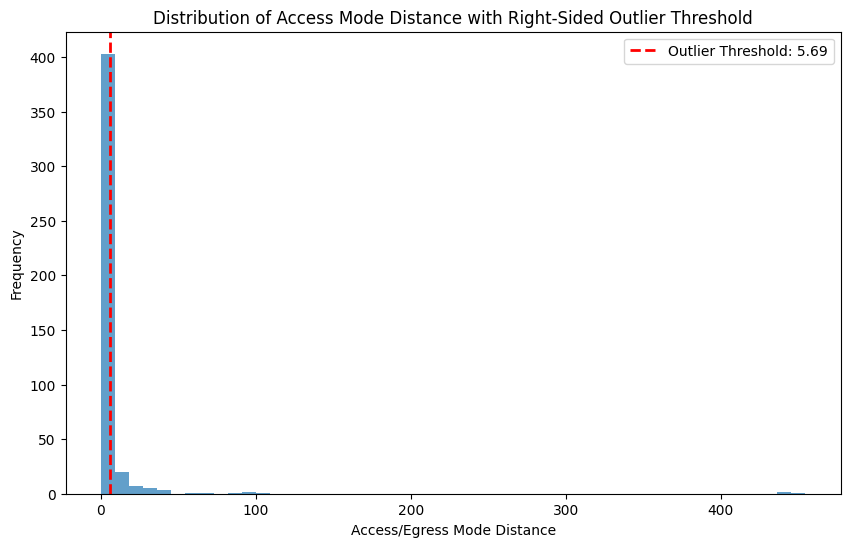

In [57]:
plot_distance_distribution(working_df)

Right-sided outlier threshold: 1.084083927581389
Number of right-sided outliers: 12


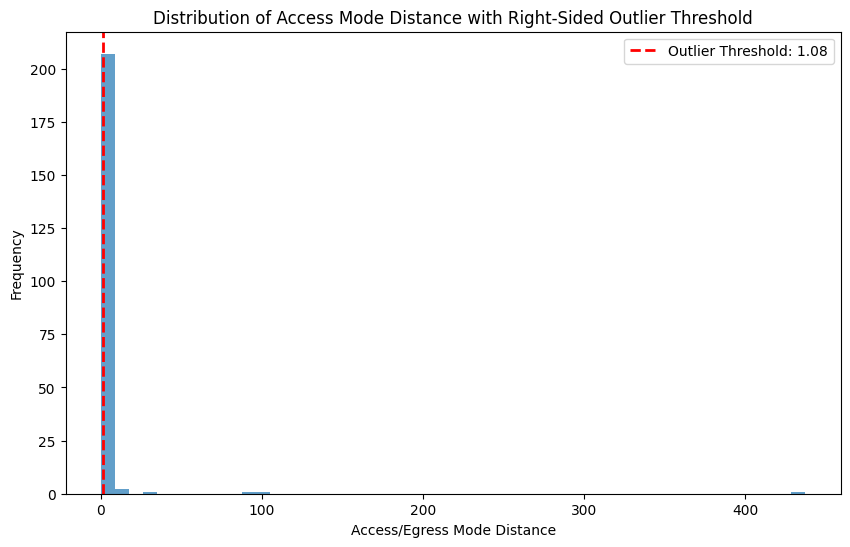

In [58]:
plot_distance_distribution(working_df[(working_df['access_mode_label']=='WALK')|(working_df['egress_mode_label']=='WALK')])

In [59]:
outliers_walk_df = working_df[((working_df['access_mode_label']=='WALK')|(working_df['egress_mode_label']=='WALK')) & (working_df['distance']>1)]

In [60]:
len(outliers_walk_df)

13

In [61]:
outliers_walk_df[['respondentid', 'distance', 'marketsegment_label']].to_csv(outliers_output_file_path, index = False)